# The Full Pipeline

**Inputs**: 
- config file
- image files
- well mask file

**Outputs**:
- droplets DataFrame (csv) 
- wells DataFrame (csv)
- condensed DataFrame (csv)
- jupyter notebook pre-loaded with basic quality control plots

We have built all the necessary parts in other python notebooks and moved code to kchip_v0 package. Now, implement each step. 

#### Step 1: Create droplets DataFrame
The droplets dataFrame contains information of all droplets in the pre-merge image set. We need to compute and store:
- the RGB information of each droplet
- the cluster and cluster label of each droplet
- the location of each droplet
- the well ID of each droplet

All of these steps can be found in the "Putting it together" notebook. 

#### Step 2: Create wells DataFrame
- Loop through post-merge images and identify wells
- Map post-merge wells to pre-merge wells
- Condense outputs to final dataframe

All of these steps can be found in the "Registration" notebook and Final Outputs. 


### Step 0: Imports and config

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
#set up the google colab

Found GPU at: /device:GPU:0


In [0]:
googlepath = "/content/drive/My Drive/"

In [0]:
pip install -U PyYAML

     |████████████████████████████████| 276kB 10.6MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=40c5c800ad100c8895e93bcfa45226a7aa9a696b4b2b7f9806c1d1e774b71def
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [0]:
# basic imports 
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Append top level directory with kchip package
#import sys
#sys.path.append('/Users/mandy/Develop/PyCharm/BPCP/')

# kchip imports
import analyze as kchip_analyze
import ii as kchip_io
# Other
%matplotlib inline

# Read in config file
with open('{}Broad/kchip-master/kchip-master/Accessory/config/config24.yml'.format(googlepath), 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
print(yaml.dump(config)) #need test case to get atleast some files read,Notes and masks read

barcodes:
  cluster:
    eps: 0.01
    min_samples: 10
    offset:
    - 600
    - 600
    - 600
    points_to_cluster: 2000
  path: /content/drive/My Drive/Broad/kchip-master/kchip-master/Accessory/Notes.xlsx
image:
  base_path: /content/drive/My Drive/Chip24_data/
  bugs: 0
  dyes:
  - 1
  - 3
  - 2
  names:
    premerge: Chip24_premerge
    t0: Chip24_t0
    t1: Chip24_t1
    t2: Chip24_t2
  overlap: 0.05
  pixel_size: 6.5
  size: 1024
  well_start_image:
  - 1
  - 1
  well_start_xy:
  - 518
  - 434
well_mask:
  filename: /content/drive/My Drive/Broad/kchip-master/kchip-master/Accessory/Well
    Masks/k2_mask.tif
  pixel_size: 8.33625
  well_start_xy:
  - 242
  - 378



In [0]:
fontsize = 14
plt.rcParams['axes.spines.right']=False
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.linewidth']=3
plt.rcParams['axes.labelsize']=fontsize
plt.rcParams['lines.linewidth']=2
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['contour.negative_linestyle'] = 'solid'

plt.rcParams['savefig.bbox']='Tight'
plt.rcParams['pdf.fonttype'] = 42

### Step 1: Create droplets DataFrame
- Initialize from images
- Identify droplets in the same well from fit to masks
- Cluster
- Map apriori labels to clusters

In [0]:
########RUN AFTER RUNNING INTERACTIVE EXAMPLE################

#Convert droplets csv into droplets dataframe
import pandas as pd
droplets = pd.read_csv('droplets_quality_plot.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Creating droplets from: 1,1
Creating droplets from: 1,2
Creating droplets from: 1,3
Creating droplets from: 1,4
Creating droplets from: 1,5
Creating droplets from: 1,6
Creating droplets from: 1,7
Creating droplets from: 2,1
Creating droplets from: 2,2
Creating droplets from: 2,3
Creating droplets from: 2,4
Creating droplets from: 2,5
Creating droplets from: 2,6
Creating droplets from: 2,7
Creating droplets from: 3,1
Creating droplets from: 3,2
Creating droplets from: 3,3
Creating droplets from: 3,4
Creating droplets from: 3,5
Creating droplets from: 3,6
Creating droplets from: 3,7
Creating droplets from: 4,1
Creating droplets from: 4,2
Creating droplets from: 4,3
Creating droplets from: 4,4
Creating droplets from: 4,5
Creating droplets from: 4,6
Creating droplets from: 4,7
Creating droplets from: 5,1
Creating droplets from: 5,2
Creating droplets from: 5,3
Creating droplets from: 5,4
Creating droplets from: 5,5
Creating droplets from: 5,6
Creating droplets from: 5,7
Creating droplets fr

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Apriori map values are :{'ArabinoseD': [0, 0, 50], 'Ribose': [0, 5, 45], 'Mannitol': [0, 10, 40], 'Glycerol01': [0, 15, 35], 'Raffinose': [0, 20, 30], 'Iso1': [0, 25, 25], 'Iso9': [0, 30, 20], 'Iso17': [0, 35, 15], 'ArabinoseL': [0, 40, 10], 'GlcNAc': [0, 45, 5], 'Sorbitol': [0, 50, 0], 'Glutamine': [5, 0, 45], 'Melezitose': [5, 5, 40], 'Iso2': [5, 10, 35], 'Iso10': [5, 15, 30], 'Iso18': [5, 20, 25], 'Xylose': [5, 25, 20], 'Citrate': [5, 30, 15], 'Glucose01': [5, 35, 10], 'Arginine': [5, 40, 5], 'Arabinogalactan': [5, 45, 0], 'Iso3': [10, 0, 40], 'Iso11': [10, 5, 35], 'Iso19': [10, 10, 30], 'Fructose': [10, 15, 25], 'Succinate': [10, 20, 20], 'Pyruvate01': [10, 25, 15], 'Trehalose': [10, 30, 10], 'Proline01': [10, 35, 5], 'Iso4': [10, 40, 0], 'Iso12': [15, 0, 35], 'Iso20': [15, 5, 30], 'Galactose': [15, 10, 25], 'Fumarate': [15, 15, 20], 'Proline': [15, 20, 15], 'Cellobiose': [15, 25, 10], 'Sucrose01': [15, 30, 5], 'Iso5': [15, 35, 0], 'Iso13': [20, 0, 30], 'Iso21': [20, 5, 25], 'Gluco

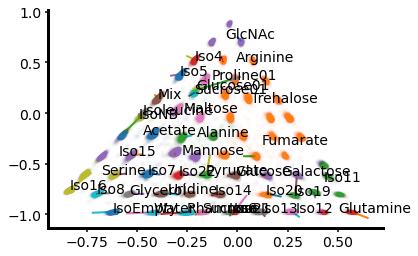

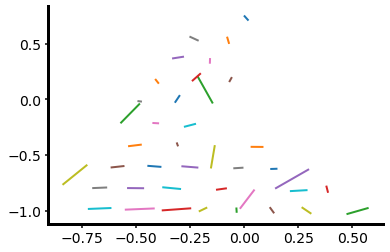

In [0]:

####################################### THIS PART IS NOT RUN SINCE DROPLET FRAME IS LOADED ##########################################################

# Initialize droplets DataFrame from images
droplets, rotation_theta = kchip_analyze.initialize_droplets(config) #return droplet dataframe and rotation axis

print('Rotation (degrees): ', rotation_theta*180/np.pi)

# Identify droplets in the same well from fit to masks
droplets = kchip_analyze.fit_droplets_to_mask(config,droplets,rotation_theta) #this is using a mask

print(f'This is the droplet dataframe {droplets} and droplet shape {droplets.shape[0]}')

# Cluster droplets and map apriori labels to clusters...why are test cases running/??
droplets, centroids = kchip_analyze.identify_clusters(config,droplets,show=1)

print('Total droplets identified: ', droplets.shape[0])

### Step 2: Create wells DataFrame
- Create pre-merge wells dataFrame
- Loop through post-merge images and identify wells
- Map post-merge wells to pre-merge wells

In [0]:
# Identify premerge wells
pre_wells = droplets.groupby(['IndexX','IndexY','Well_ID'],as_index=False)[['ImageX','ImageY','Edge']].mean()

# List of timepoints
timepoints = ['t'+str(i) for i in range(3)]

# Analyze data for each timepoint
pre_post_all = []
for timepoint in timepoints:
    print ('Now analyzing timepoint: ', timepoint)
    # Identify postmerge wells and map to pre-merge wells
    pre_post_all.append(kchip_analyze.map_pre_to_post(config,timepoint,pre_wells))
    pre_post_all[-1].to_csv(timepoint+'.csv')

# Condense output
condensed = kchip_analyze.stack_timepoints(droplets,pre_post_all,timepoints)

Now analyzing timepoint:  t0
Now analyzing: 1,1
Now analyzing: 1,2
Now analyzing: 1,3
Now analyzing: 1,4
Now analyzing: 1,5
Now analyzing: 1,6
Now analyzing: 1,7
Now analyzing: 2,1
Now analyzing: 2,2
Now analyzing: 2,3
Now analyzing: 2,4
Now analyzing: 2,5
Now analyzing: 2,6
Now analyzing: 2,7
Now analyzing: 3,1
Now analyzing: 3,2
Now analyzing: 3,3
Now analyzing: 3,4
Now analyzing: 3,5
Now analyzing: 3,6
Now analyzing: 3,7
Now analyzing: 4,1
Now analyzing: 4,2
Now analyzing: 4,3
Now analyzing: 4,4
Now analyzing: 4,5
Now analyzing: 4,6
Now analyzing: 4,7
Now analyzing: 5,1
Now analyzing: 5,2
Now analyzing: 5,3
Now analyzing: 5,4
Now analyzing: 5,5
Now analyzing: 5,6
Now analyzing: 5,7
Now analyzing: 6,1
Now analyzing: 6,2
Now analyzing: 6,3
Now analyzing: 6,4
Now analyzing: 6,5
Now analyzing: 6,6
Now analyzing: 6,7
Now analyzing: 7,1
Now analyzing: 7,2
Now analyzing: 7,3
Now analyzing: 7,4
Now analyzing: 7,5
Now analyzing: 7,6
Now analyzing: 7,7
Now analyzing: 8,1
Now analyzing: 8,2
No

In [0]:
# Save outputs
droplets.to_csv('droplets.csv')
condensed.to_csv('output.csv')

## Quality control outputs

### Chip loading and global well positions

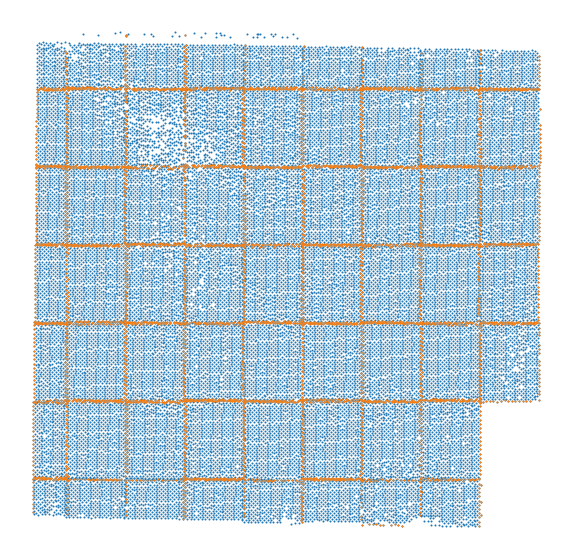

In [0]:
well_positions = pre_post_all[-1].groupby('Hash').mean()[['Pre_GlobalX','Pre_GlobalY']].values
edge = pre_post_all[-1].groupby('Hash').mean()['Pre_Edge'].values

fig, axes = plt.subplots(figsize=(10,10))

axes.plot(well_positions[:,0],-well_positions[:,1],'.',ms=2)
axes.plot(well_positions[edge,0],-well_positions[edge,1],'.',ms=2)
plt.axis('off');

### Plot by total droplets in well

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


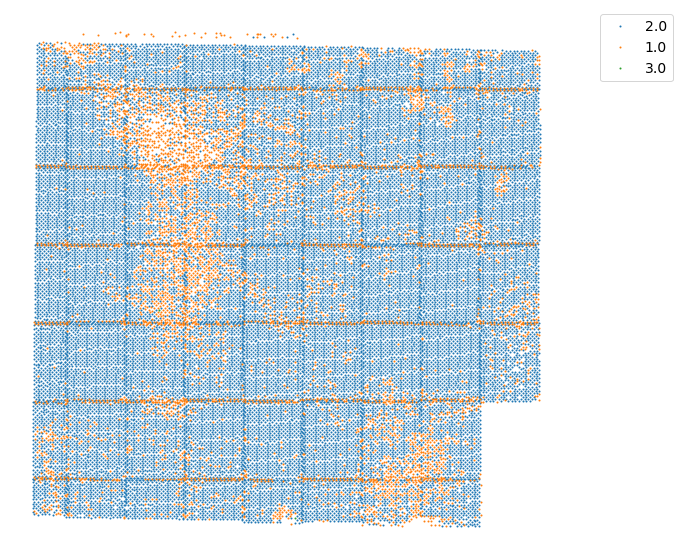

In [0]:
def plot_by_count(df,ax):
    for item in df['Total'].unique():
        pos = df[(df['Total']==item)][['Pre_GlobalX','Pre_GlobalY']].values
        ax.plot(pos[:,0],-pos[:,1],'.',ms=2)
    return ax

fig, axes = plt.subplots(figsize=(10,10))
        
condensed[['Hash','Total','t2_Area']] \
    .merge(pre_post_all[-1][['Hash','Pre_GlobalX','Pre_GlobalY','Pre_Edge']],on='Hash') \
    .pipe(plot_by_count,ax=axes) 
    
axes.legend(condensed['Total'].unique(),loc=2,bbox_to_anchor=(1.05,1))
plt.axis('off');

### Plot area over chip

Text(0, 0.5, 'Count')

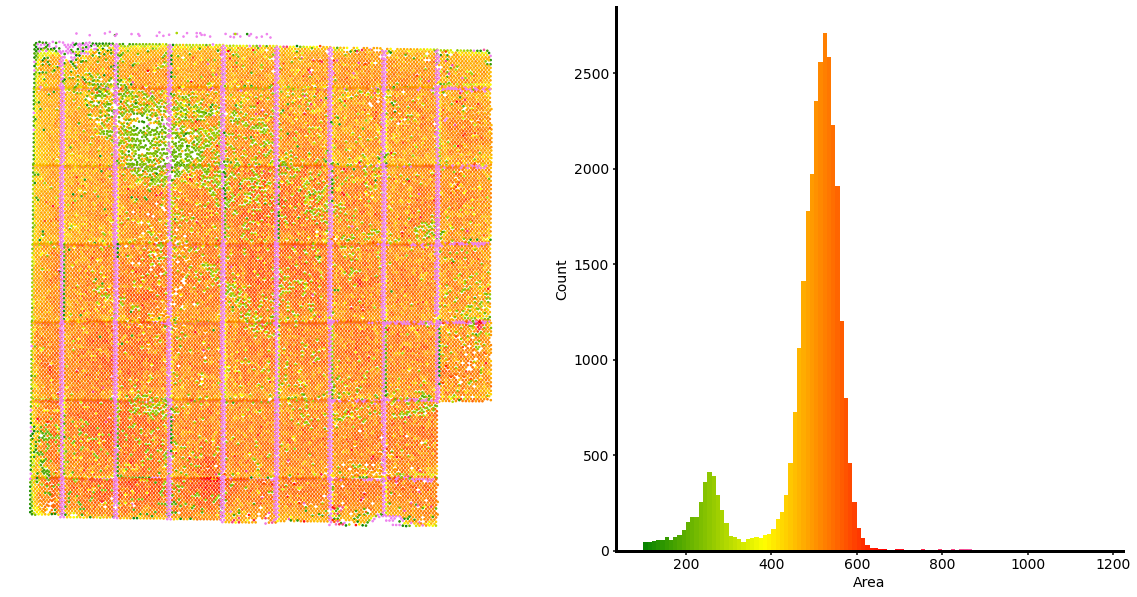

In [0]:
from matplotlib import colors

data = condensed[['Hash','Total','t2_Area']] \
    .merge(pre_post_all[-1][['Hash','Pre_GlobalX','Pre_GlobalY','Pre_Edge']],on='Hash') 

width = 1e1
bins = np.arange(0,2e3,width)

bin_by_area = pd.cut(data['t2_Area'],bins)
bin_label = dict([(item,i) for i, item in enumerate(bin_by_area.unique().sort_values())])

data['Area_Bin']=[bin_label[item] for item in bin_by_area]

cmap = colors.LinearSegmentedColormap.from_list('', ['green','yellow','red','violet'],N=data['Area_Bin'].max())

fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(data['Pre_GlobalX'],-data['Pre_GlobalY'],c=data['Area_Bin'],cmap=cmap,marker='.',s=10,alpha=1)
axes[0].axis('off')

invert_label = {v: k for k, v in bin_label.items()}

for label in invert_label.keys():
    if invert_label[label]==invert_label[label]:
        axes[1].bar(invert_label[label].mid,(data['Area_Bin']==label).sum(),width=width,color=cmap(label))

axes[1].set_xlabel('Area')
axes[1].set_ylabel('Count')

### Representation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Representation')

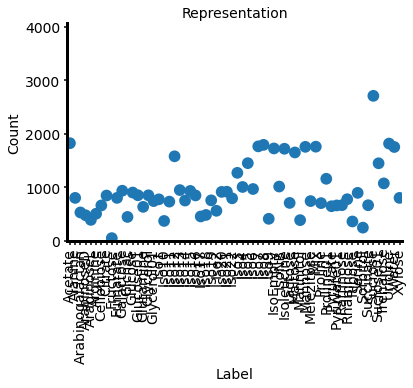

In [0]:
import seaborn as sns

fig, ax = plt.subplots()

p = sns.pointplot(data=droplets.groupby('Label').count().reset_index(),x='Label',y='RX',join=False)

p.set_xticklabels(p.get_xticklabels(),rotation=90)
p.set_ylim([0,droplets.groupby('Label').count()['RX'].max()*1.5]);
p.set_ylabel('Count')
p.set_title('Representation')

### Histograms of GFP and Area values

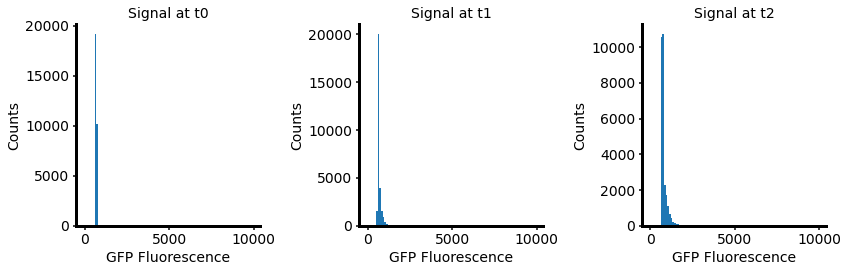

In [0]:
timepoints = condensed.filter(regex='t\d+(?!_)').columns.values

fig, axes = plt.subplots(1,len(timepoints),figsize=(4*len(timepoints),4))

bins = np.arange(0,1e4,1e2)

for ax, t in zip(axes,timepoints):
    ax.hist(condensed[t].dropna(),bins=bins)
    ax.set_xlabel('GFP Fluorescence')
    ax.set_ylabel('Counts')
    ax.set_title('Signal at '+t)

plt.tight_layout()

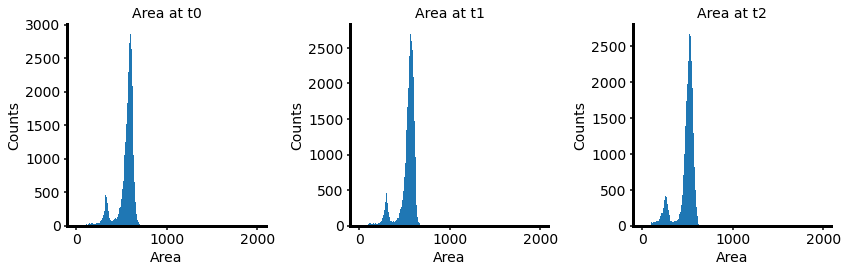

In [0]:
timepoints = condensed.filter(regex='t\d+_Area').columns.values

fig, axes = plt.subplots(1,len(timepoints),figsize=(4*len(timepoints),4))

bins = np.arange(0,2e3,1e1)

for ax, t in zip(axes,timepoints):
    ax.hist(condensed[t].dropna(),bins=bins)
    ax.set_xlabel('Area')
    ax.set_ylabel('Counts')
    ax.set_title('Area at '+t[:-5])

plt.tight_layout()